In [1]:
import google.colab as colab
import shutil
import os
import pandas as pd
import random
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

Using TensorFlow backend.


In [0]:
embedding_dim = 300
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

### Mount Google Drive

In [0]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root

def get_all_files_from_dir(directory):

    '''
    # Functionality
    Get the whole list of files in a folder
	# Arguments
		directory: string.  (e.g.,Users/laowang/~vgg/data/flowers/102/102flowers.tgz)
	# Returns
		None
	'''
    file_paths = []
    for root, dirs, files in os.walk(directory):
        file_paths += [os.path.join(root, x) for x in files]
    return sorted(file_paths)

In [4]:
ROOT_DIR =  mount_google_drive() + "/ECE457B-Project/"
DATASET_DIR = ROOT_DIR + "sec8ks/"
print(DATASET_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/ECE457B-Project/sec8ks/


## Load NLP Sentences

In [0]:
modified_results = np.load(ROOT_DIR + "sec_modified.npy", allow_pickle=True)

In [6]:
modified_results

array([[datetime.date(2010, 1, 19),
        'indenture salesforcecom inc us bank national association dated january 19 2010 purchase agreement dated january 12 2010 salesforcecom inc merrill lynch pierce fenner smith incorporated representative several initial purchasers named schedulea thereto form convertible bond hedge confirmation form warrant confirmation press release dated january 19 2010 announcing closing offering notes'],
       [datetime.date(2010, 1, 19),
        'indenture salesforcecom inc us bank national association dated january 19 2010 purchase agreement dated january 12 2010 salesforcecom inc merrill lynch pierce fenner smith incorporated representative several initial purchasers named schedulea thereto form convertible bond hedge confirmation form warrant confirmation press release dated january 19 2010 announcing closing offering notes'],
       [datetime.date(2010, 4, 21), 'press release dated april 21 2010'],
       [datetime.date(2010, 4, 21), 'press release dat

In [7]:
sentences = modified_results[:, 1].tolist()
sentences[:10]

['indenture salesforcecom inc us bank national association dated january 19 2010 purchase agreement dated january 12 2010 salesforcecom inc merrill lynch pierce fenner smith incorporated representative several initial purchasers named schedulea thereto form convertible bond hedge confirmation form warrant confirmation press release dated january 19 2010 announcing closing offering notes',
 'indenture salesforcecom inc us bank national association dated january 19 2010 purchase agreement dated january 12 2010 salesforcecom inc merrill lynch pierce fenner smith incorporated representative several initial purchasers named schedulea thereto form convertible bond hedge confirmation form warrant confirmation press release dated january 19 2010 announcing closing offering notes',
 'press release dated april 21 2010',
 'press release dated april 21 2010',
 'press release dated october 27 2010',
 'agreement plan merger dated december7 2010 among salesforcecom inc hiiaka acquisition corporation 

In [0]:
# Set up tokenizer and convert text to numerial sequences
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

In [9]:
word_index = tokenizer.word_index
vocab_size=len(word_index)
vocab_size

303

In [0]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [0]:
assert padded.shape[0] == len(sentences)

In [40]:
padded.shape

(47, 100)

In [13]:
sequences = padded.tolist()
dates = modified_results[:, 0].tolist()

df_nlp = pd.DataFrame(list(zip(dates, sequences)), columns =['Date', 'Features']) 
df_nlp.set_index("Date")
df_nlp.head()

,Date,Features
0,2010-01-19,"[61, 4, 3, 30, 11, 25, 26, 2, 48, 75, 17, 36, ..."
1,2010-01-19,"[61, 4, 3, 30, 11, 25, 26, 2, 48, 75, 17, 36, ..."
2,2010-04-21,"[7, 8, 2, 79, 39, 17, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2010-04-21,"[7, 8, 2, 79, 39, 17, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2010-10-27,"[7, 8, 2, 205, 206, 17, 0, 0, 0, 0, 0, 0, 0, 0..."


## Set up word embedding model

In [0]:
# Takes 3 mins to load
embeddings_index = {};
with open(ROOT_DIR + 'glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split();
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

## Load time series dataset


In [0]:
df_tseries = pd.read_csv(ROOT_DIR + 'CRM.csv',index_col="Date",parse_dates=True)

In [29]:
df_tseries.shape

(2549, 6)

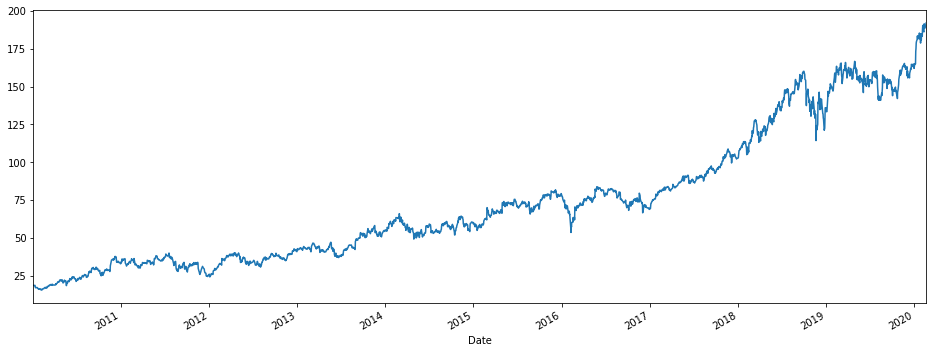

In [30]:
df_tseries['Open'].plot(figsize=(16,6))

In [0]:
# # convert column "a" of a DataFrame
# df_tseries["Close"] = df_tseries["Close"].str.replace(',', '').astype(float)
# df_tseries["Volume"] = df_tseries["Volume"].str.replace(',', '').astype(float)

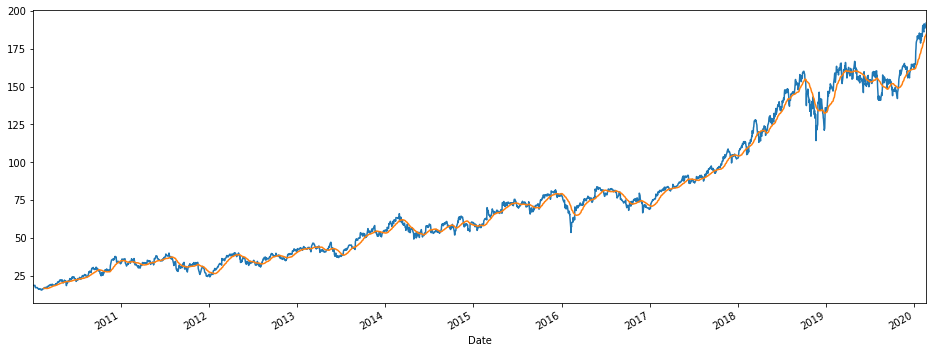

In [32]:
df_tseries['Open'].plot(figsize=(16,6))
df_tseries.rolling(window=30).mean()['Close'].plot()

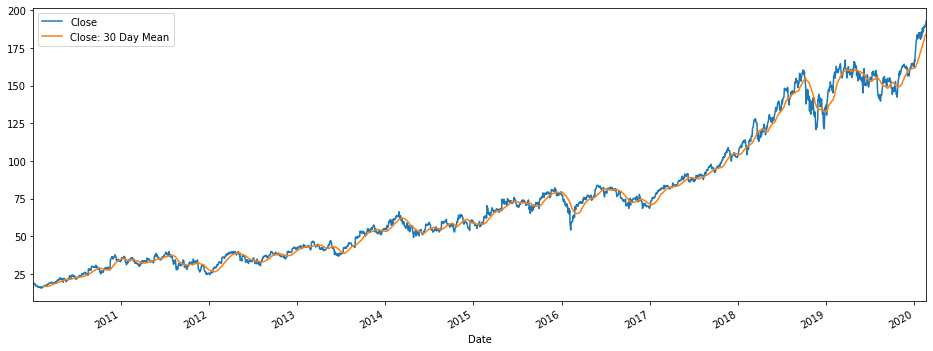

In [33]:
df_tseries['Close: 30 Day Mean'] = df_tseries['Close'].rolling(window=30).mean()
df_tseries[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))

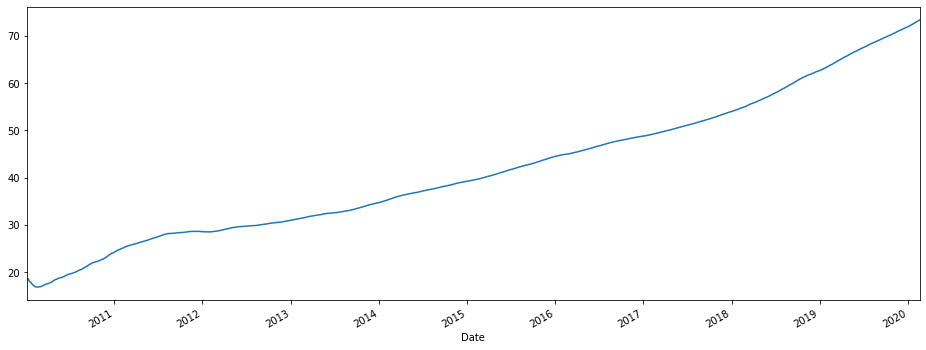

In [34]:
# Optional specify a minimum number of periods
df_tseries['Close'].expanding(min_periods=1).mean().plot(figsize=(16,6))

## Merge two dataframes


In [35]:
print(type(df_tseries))
print(type(df_nlp))

print(df_tseries.shape)
print(df_nlp.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(2549, 7)
(47, 2)


In [0]:
merged_df = df_tseries.join(df_nlp)

In [0]:
isnull = merged_df.Features.isnull()
merged_df.loc[isnull, 'Features'] = [ [[0] * 100] * isnull.sum() ]
merged_df

In [51]:
merged_df[["Open", "Features"]]

,Open,Features
Date,,
2010-01-04,18.652500,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2010-01-05,18.612499,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2010-01-06,18.687500,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2010-01-07,18.629999,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2010-01-08,18.517500,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
2020-02-12,189.710007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2020-02-13,188.500000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2020-02-14,189.350006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
